In [1]:
import numpy as np
from __future__ import division
import matplotlib.pyplot as plt
from IPython import display
import cvxpy as cvx
import math
import sys
import time

%matplotlib inline

/Users/pagi/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


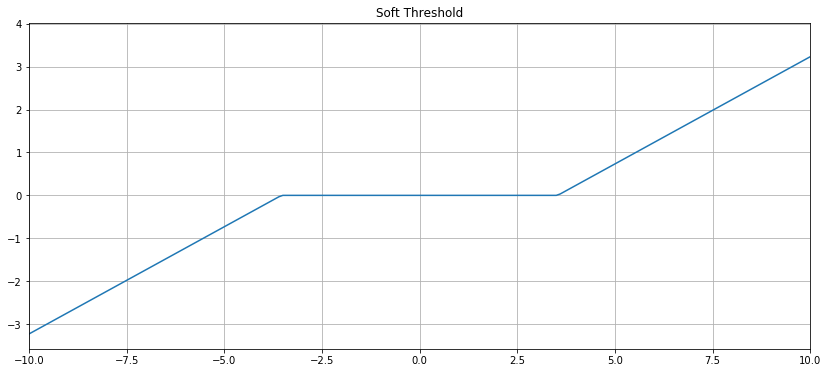

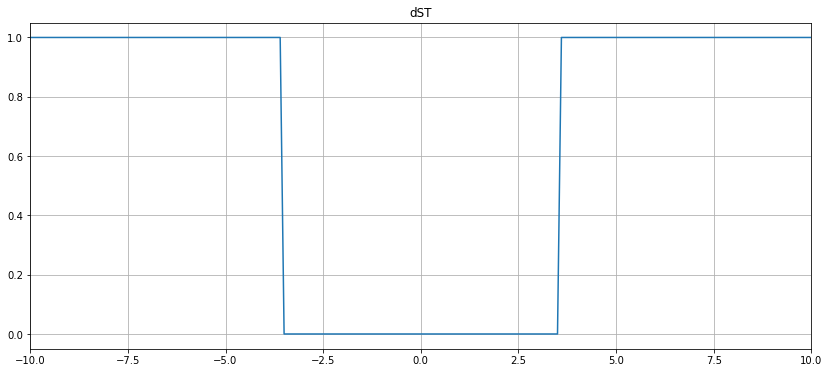

In [2]:
## Paraphernalia

# Cost Function
def F(A, x, b, lamb=0):
    f = 0.5 * (np.linalg.norm(A@x - b, 2))**2
    g = lamb * np.linalg.norm(x, 1)
    return (f + g)

# Lipschitz's constant for l1 regularization
def L(A):
    return np.real(2*max(np.linalg.eigvals(A.T@A)))

# (Complex) Soft Threshold 
def SoftThreshComplex(y, lamb):
    res = np.abs(y)
    res = (np.maximum(0 , res - lamb)) / res
    np.nan_to_num(res)
    return y * res

# Derivative of (Complex) Soft Threshold
def dST(y, lamb):
    res = np.abs(y) - lamb
    xhat = res
    xhat[res < 0] = 0
    xhat[res > 0] = 1
    np.nan_to_num(xhat)
    return xhat

# Stem plot printing 
def printing(x,i,lamb):
    plt.clf()
    plt.stem(x)
    plt.title( 'Iteration {}, lambda {}'.format(i,lamb) )
    display.clear_output(wait=True)
    display.display(plt.gcf())

def numericalDiff(f, x, lamb=None):
    dx = 1e-12
    f1 = f(x+dx,lamb)
    f2 = f(x-dx,lamb)
    return (f1 - f2) / (2 * dx)

    # plotting tests
idxa = np.arange(-10, 11, .1)
idxb = 0.5 * idxa + 0.5 * 1j * idxa ## to test complex values

plt.figure(figsize=(14, 6))
plt.plot(idxa, SoftThreshComplex(idxb, 2.5))
plt.xlim((-10, 10))
plt.title('Soft Threshold')
plt.grid()

plt.figure(figsize=(14, 6))
plt.plot(idxa, dST(idxb, 2.5))
plt.xlim((-10, 10))
plt.title('dST')
plt.grid()

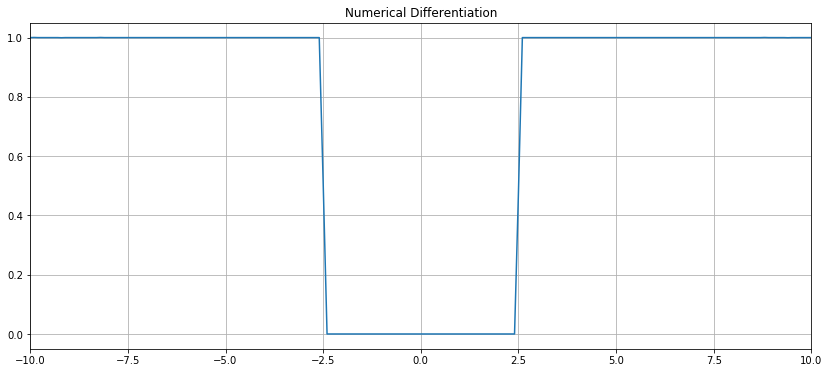

In [3]:
idxd = [numericalDiff(SoftThreshComplex,x,2.5) for x in idxa]
plt.figure(figsize=(14, 6))
plt.plot(idxa, idxd)
plt.xlim((-10, 10))
plt.title('Numerical Differentiation')
plt.grid()

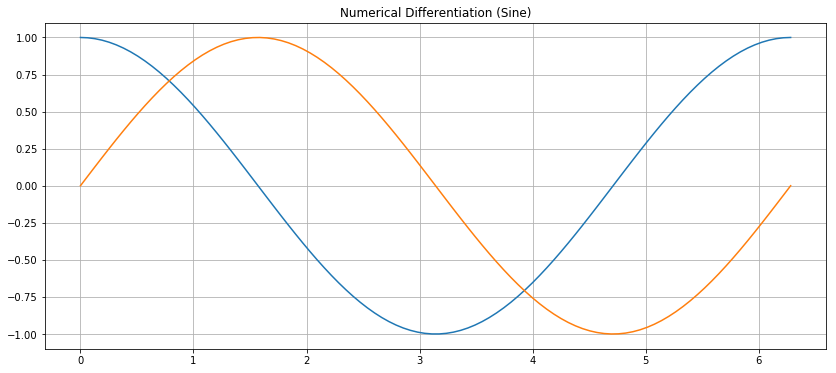

In [4]:
qwert = np.linspace(0, 2*np.pi, 100)
idxe = [numericalDiff(np.sin,x) for x in qwert]
plt.figure(figsize=(14, 6))
plt.plot(qwert, idxe, qwert, np.sin(qwert))
# plt.xlim((-10, 10))
plt.title('Numerical Differentiation (Sine)')
plt.grid()

In [5]:
def ISTA(A, b, niter, lamb, x_true=None): 
    ATA = np.matrix.getH(A) @ A
    ATb = np.matrix.getH(A) @ b
    ST = SoftThreshComplex
    objval = np.zeros(niter, dtype='complex')
    trueval = np.zeros(niter, dtype='complex')
    x_i = ATb.copy()
    t = 1/(L(A))
    for i in range(niter):
        x_i = ST(x_i - 2*t*((ATA @ x_i) - ATb), lamb * t)
        objval[i] = F(A,x_i,b,lamb)
        if (x_true != None):
            trueval[i] = np.linalg.norm(x_i - x_true)
#         if i%100 == 0:    
#             printing(x_i, i, lamb * t )
    return x_i, objval, trueval

In [6]:
def FISTA(A, b, niter, lamb, x_true=None):
    ATA = np.matrix.getH(A) @ A
    ATb = np.matrix.getH(A) @ b
    ST = SoftThreshComplex
    objval = np.zeros(niter, dtype='complex')
    trueval = np.zeros(niter, dtype='complex')
    l = 1/L(A)
    y = ATb.copy() 
    x_new = y
    t_new = 1
    for i in range(1,niter):
        x_old = x_new
        x_new = ST(y - 2*l*((ATA @ y) - ATb), lamb * l)
        t_old = t_new
        t_new = ( ( 1 + math.sqrt(1 + 4 * t_old * t_old) ) / 2 )
        y = x_new + ( (t_old - 1)/(t_new) ) * ( x_new - x_old )
        objval[i] = F(A,x_new,b,lamb)
        if (x_true != None):
            trueval[i] = np.linalg.norm(x_new - x_true)
    return x_new, objval, trueval

In [18]:
def AMP(A, y, niter, cutoff, x_true=None):
    # Declaring Variables 
    AT = np.matrix.getH(A)
    ATy = AT @ y
    x = np.zeros((niter,len(ATy))) # Estimate
    z = np.zeros((niter,len(y))) # Innovation
    lamb = np.zeros(niter)  # Threshold parameter
    ST = numericalDiff
    trueval = np.zeros(niter, dtype='complex')
    weight = (1/A.shape[0]) # 1 / n 
    x[0] = (ATy).copy() # Initiate estimate
    z[0] = y.copy()  # Initiate innovation
    for i in range(1,niter):
#         printing(x[i],i,i)
        
        #  Calculating x
        gamma_amp = x[i-1] + AT @ z[i-1]
        tmp=sorted(abs(gamma_amp), reverse=True)
        lamb[i] = tmp[cutoff]
#         [numericalDiff(SoftThreshComplex,x,2.5) for x in idxa]
        x[i] = ST(SoftThreshComplex, gamma_amp, lamb[i])
        #  Calculating z
#         z[i] = (y - A @ x[i]) + z[i-1] / (A.shape[0]) * sum(abs(gamma_amp) > lamb[i])
        z[i] = (y - A @ x[i]) + z[i-1] * weight * sum(dST(gamma_amp,lamb[i])) 
        
        if(x_true != None):
            trueval[i] = np.linalg.norm(x_true - x[i])

    return x[-1], trueval

In [8]:
def ADMM(A, y, niter, lamb, x_true=None):
    m, n = A.shape
    np.matrix.getH
    ATA = np.matrix.getH(A) @ A
    ATy = np.matrix.getH(A) @ y
    w = np.linalg.eigvals(ATA)
    ST = SoftThreshComplex 
    
    # Variables to caluculate min 1/2(y - Ax) + l||x|| via alternating direction methods
    x_hat = ATy.copy()
    z_hat = np.zeros(n)
    u = np.zeros(n)
    trueval = np.zeros(niter)
    
    # Calculate regression co-efficient and stepsize
    rho = L(A) 
    lamb_over_rho =  lamb / rho # I might be wrong here
    
    # Pre-compute to save some multiplications
    Q = ATA + rho * np.identity(n)
#     Q = np.linalg.inv(Q)
#     Q_dot = Q.dot
    sign = np.sign
    maximum = np.maximum
    absolute = np.absolute
    lstsq = np.linalg.lstsq

    for i in range(1,niter):
        # x minimization step via posterier OLS
        b = ATy + rho * (z_hat - u)
        x_hat =  lstsq(Q,b)[0]
#         print(x_hat.shape)
        # z minimisation via soft-thresholding
        u = x_hat + u
        z_hat = ST(u, lamb_over_rho)
        # mulitplier update
        u = u - z_hat
        
        if(x_true != None):
            trueval[i] = np.linalg.norm(x_true - x_hat)

    return x_hat, z_hat, trueval

/Users/pagi/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


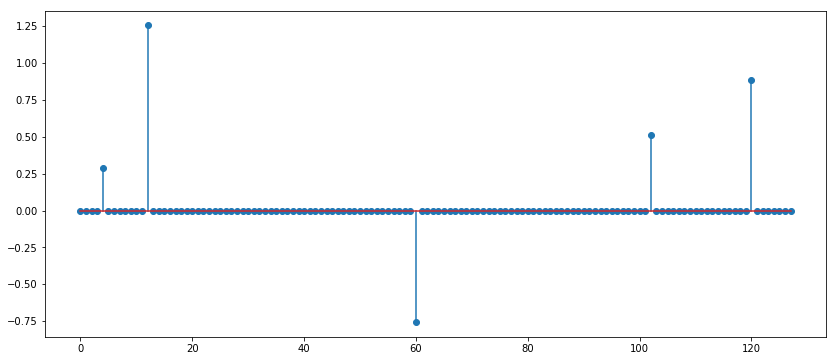

In [9]:
# Problem set-up 

gamma = 0.01
peaks = 5
n = 62 # samples
N = 128 # total size
np.random.seed(1)
prm = np.random.permutation(N) - 1
idx =  prm[:n]
peakList = [np.random.randn() for i in range(peaks)]
x = np.array(  peakList + [0] * (N-peaks), dtype='complex' )
x = x[ np.random.permutation(N) - 1 ]
plt.figure(figsize=(14, 6))
plt.stem(x)

A = np.zeros((N,N), dtype='complex')
A[idx] = np.fft.fft(np.identity(N))[idx]
b = A @ x

/Users/pagi/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


numpy ls: 0.252532645432


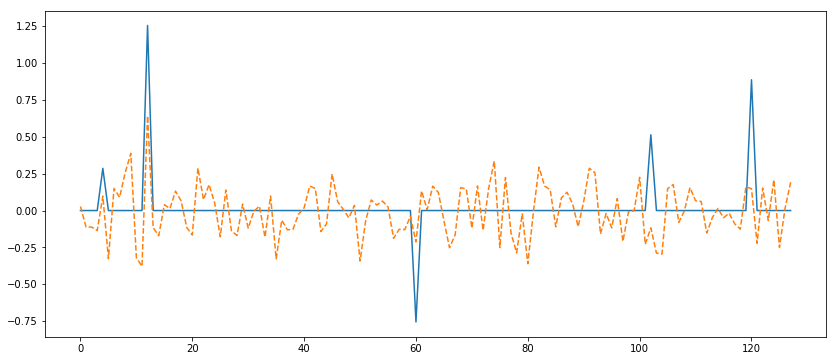

In [10]:
## LEAST SQUARES
x_ls = np.linalg.lstsq(A, b)[0]
ls = F(A,x_ls,b, gamma) 

plt.figure(figsize=(14, 6))
plt.plot(range(N), x, range(N), x_ls, '--')

print("numpy ls: " +str(ls))

ISTA runtime for 100000 iterations: 11.775790929794312 seconds


/Users/pagi/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


F(x_IST) = 0.0369059158059
F(x_LS) = 0.252532645432


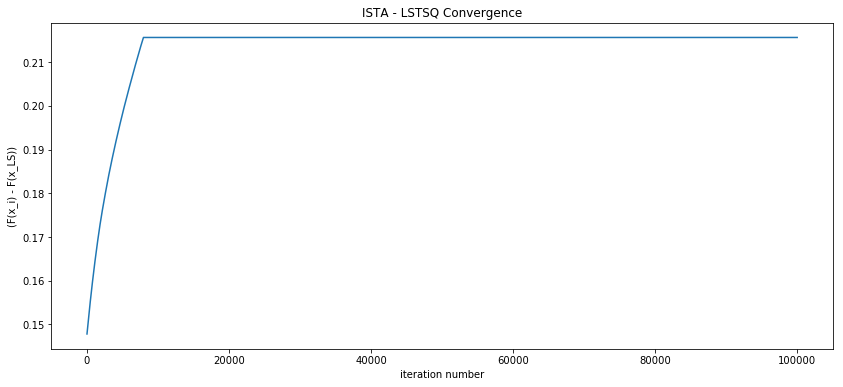

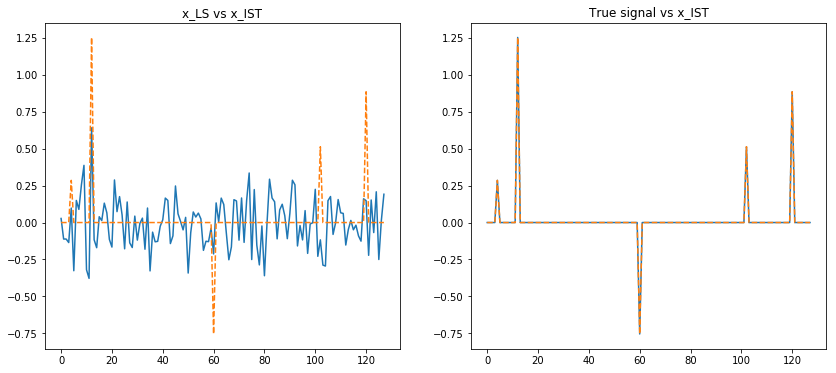

In [11]:
#  def ISTA(A, b, niter, lamb, x_true=None): 
nitr = 100000
tic = time.time()
x_IST, F_IST, TSE_IST = ISTA(A, b, nitr, gamma)
toc = time.time()
print('ISTA runtime for', str(nitr), 'iterations:', toc - tic, 'seconds')
ist = F(A, x_IST, b, gamma)

plt.figure(figsize=(14, 6))
plt.plot(abs(F(A, x_ls, b, gamma) - F_IST))
plt.xlabel('iteration number')
plt.ylabel('(F(x_i) - F(x_LS))')
plt.title('ISTA - LSTSQ Convergence')

if sum(TSE_IST) > 0:
    plt.figure(figsize=(14, 6))
    plt.plot(TSE_IST/np.linalg.norm(x))
    plt.xlabel('iteration number')
    plt.ylabel('Normalized MSE')
    plt.title('ISTA - True Signal Convergence')

plt.figure(figsize=(14, 6))
plt.subplot(1,2,1)
plt.plot(range(N), x_ls)
plt.plot(range(N), x_IST, '--')
plt.title('x_LS vs x_IST')
plt.subplot(1,2,2)
plt.plot(range(N), x)
plt.plot(range(N), x_IST, '--')
plt.title('True signal vs x_IST')

print('F(x_IST) =', ist)
print('F(x_LS) =', ls)

/Users/pagi/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


FISTA runtime for 10000 iterations: 1.5066452026367188 seconds


/Users/pagi/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


F(x_fista) = 0.0369059158059
F(x_ls) = 0.252532645432


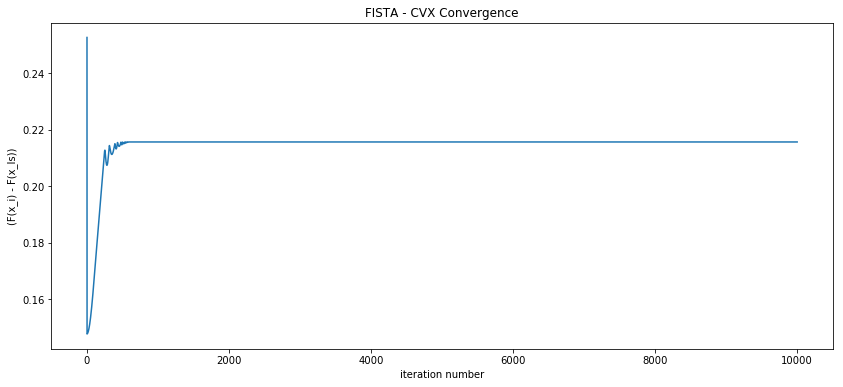

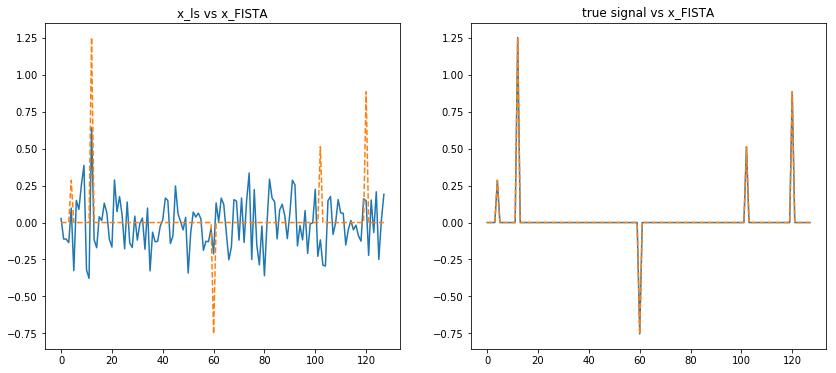

In [12]:
# def FISTA(A, b, niter, lamb, x_true=None):

nitr = 10000
tic = time.time()
x_FISTA, F_FISTA, TSE_FISTA = FISTA(A, b, nitr, gamma, x)
toc = time.time()
fista = F(A, x_FISTA, b, gamma)
print('FISTA runtime for', str(nitr), 'iterations:', toc - tic, 'seconds')
# plt.stem(x_IST)
plt.figure(figsize=(14, 6))
plt.plot(abs(F_FISTA - F(A, x_ls, b, gamma)))
plt.xlabel('iteration number')
plt.ylabel('(F(x_i) - F(x_ls))')
plt.title('FISTA - CVX Convergence')

if sum(TSE_IST) > 0:
    plt.figure(figsize=(14, 6))
    plt.semilogy(TSE_FISTA/np.linalg.norm(x))
    plt.xlabel('iteration number')
    plt.ylabel('Normalized MSE')
    plt.title('FISTA  -True Signal Convergence')

plt.figure(figsize=(14, 6))
plt.subplot(1,2,1)
plt.plot(range(N), x_ls)
plt.plot(range(N), x_FISTA, '--')
plt.title('x_ls vs x_FISTA')
plt.subplot(1,2,2)
plt.plot(range(N), x)
plt.plot(range(N), x_FISTA, '--')
plt.title('true signal vs x_FISTA')

print('F(x_fista) =', fista)
print('F(x_ls) =', ls)

/Users/pagi/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:11: ComplexWarning: Casting complex values to real discards the imaginary part
  # This is added back by InteractiveShellApp.init_path()
/Users/pagi/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  if sys.path[0] == '':
/Users/pagi/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/pagi/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:24: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/pagi/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/Users/pagi/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/numeric.py:531: Co

AMP runtime for 2 iterations: 0.0035119056701660156 seconds
2-norm(x-x_AMP) = 1.93551649122


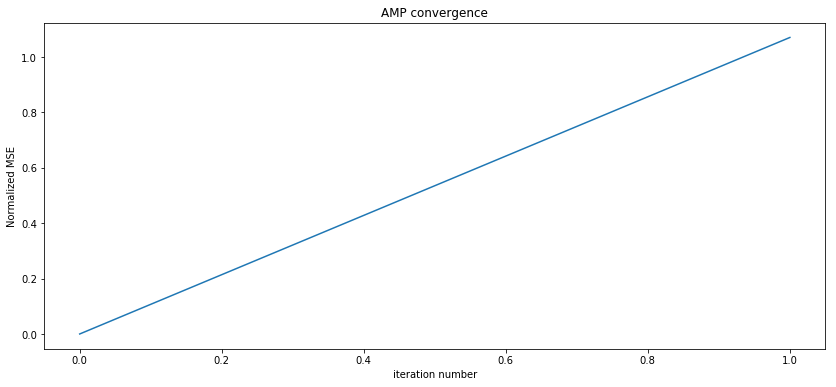

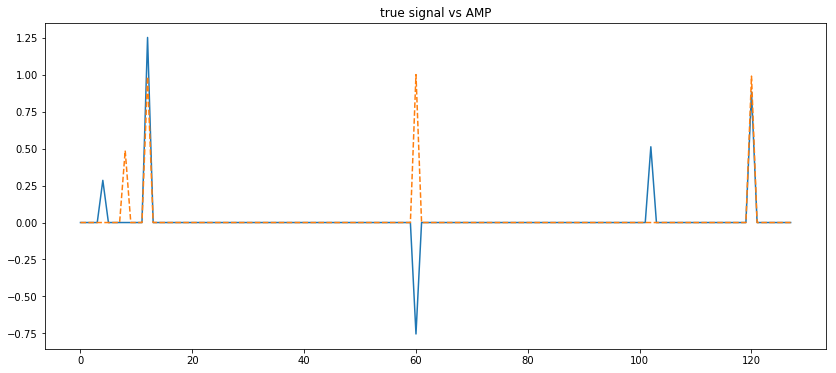

In [21]:
## AMP

nitr = 2
cutoff = 3
tic = time.time()
x_AMP, TSE_AMP = AMP(A, b, nitr, cutoff, x)
toc = time.time()
# amp = F(A, x_AMP, b, gamma)
print('AMP runtime for', str(nitr), 'iterations:', toc - tic, 'seconds')
# plt.stem(x_AMP)
plt.figure(figsize=(14, 6))
plt.plot(TSE_AMP/np.linalg.norm(x))
plt.xlabel('iteration number')
plt.ylabel('Normalized MSE')
plt.title('AMP convergence')

plt.figure(figsize=(14, 6))
plt.plot(range(N), x, range(N), x_AMP, '--')
plt.title('true signal vs AMP')

print('2-norm(x-x_AMP) =', np.linalg.norm(x - x_AMP))
# print('F(x_cvx) =', cv)


/Users/pagi/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:39: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


ADMM runtime for 10000 iterations: 35.26103401184082 seconds
F(x_ADMM) = 0.0369048063997
F(x_LS) = 0.252532645432


/Users/pagi/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


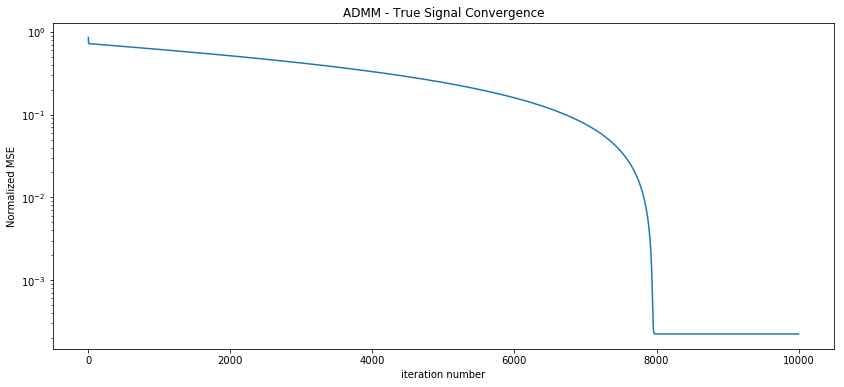

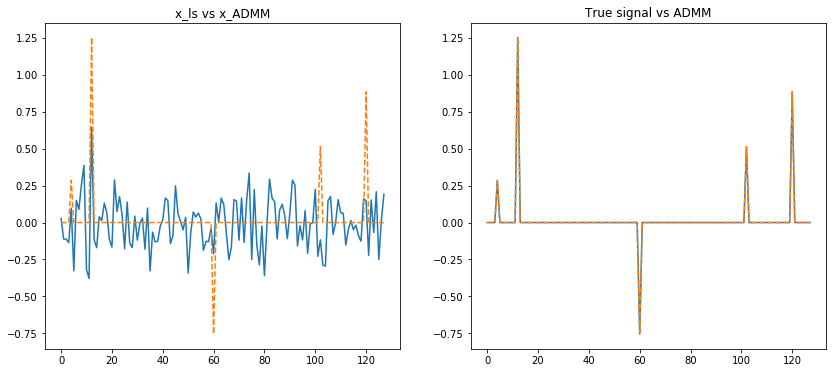

In [15]:
## def ADMM(A, y, niter, lamb, x_true=None):

nitr = 10000
tic = time.time()
x_ADMM, z_ADMM, TSE_ADMM = ADMM(A, b, nitr, gamma, x)
toc = time.time()
admm = F(A, x_ADMM, b, gamma)
print('ADMM runtime for', str(nitr), 'iterations:', toc - tic, 'seconds')
# plt.figure(figsize=(14, 6))
# plt.plot(range(nitr),admm - F(A, x_cvx, b, gamma))
# plt.xlabel('iteration number')
# plt.ylabel('(F(x_i) - F(x_cvx))')
# plt.title('ADMM - CVX Convergence')

if sum(TSE_ADMM) > 0:
    plt.figure(figsize=(14, 6))
    plt.semilogy(TSE_ADMM/np.linalg.norm(x))
    plt.xlabel('iteration number')
    plt.ylabel('Normalized MSE')
    plt.title('ADMM - True Signal Convergence')

plt.figure(figsize=(14, 6))
plt.subplot(1,2,1)
plt.plot(range(N), x_ls)
plt.plot(range(N), x_ADMM, '--')
plt.title('x_ls vs x_ADMM')
plt.subplot(1,2,2)
plt.plot(range(N), x)
plt.plot(range(N), x_ADMM, '--')
plt.title('True signal vs ADMM')

print('F(x_ADMM) =', admm)
print('F(x_fista) =', fista)
print('F(x_LS) =', ls)